In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from architectures import get_architecture
from datasets import get_dataset

# Import the Smooth class from the repository.
from core import Smooth
import csv
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def get_model(checkpoint_path='../models/cifar10/resnet110/noise_0.25/checkpoint.pth.tar', dataset='cifar10'):
    """
    load the base classifier from the checkpoint
    :param checkpoint_path: path to the checkpoint
    :param dataset: dataset name
    :return: the base classifier
    """

    # load the base classifier
    checkpoint = torch.load(checkpoint_path)
    base_classifier = get_architecture(checkpoint["arch"], dataset)
    base_classifier.load_state_dict(checkpoint['state_dict'])
    return base_classifier

In [4]:
def visualize_cifar10_img(img, label, pred_label=None):
    # CIFAR-10 label names
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    if isinstance(img, torch.Tensor):
        # Remove batch dimension if present
        if img.dim() == 4 and img.shape[0] == 1:
            img = img.squeeze(0)
        img = img.detach().cpu().numpy().transpose((1, 2, 0))

    # Unnormalize the image if needed (i.e. if its values are not already in [0, 1])
    if img.min() < 0 or img.max() > 1:
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)

    # Plot the image with both label number and label name in the title
    plt.imshow(img)
    if pred_label is not None:
        plt.title(f'Label: {label} ({label_names[label]}), Prediction: {pred_label} ({label_names[pred_label]})')
    else:
        plt.title(f'Label: {label} ({label_names[label]})')
    plt.show()

In [5]:
def visualize_cifar10_imgs(imgs, titles, ncols=3, figsize=(12, 8)):
    # CIFAR-10 label names (in case they are needed in titles)
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    nimgs = len(imgs)
    nrows = (nimgs + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if nimgs > 1 else [axes]

    for i, (img, title) in enumerate(zip(imgs, titles)):
        # Process image if it's a torch.Tensor
        if isinstance(img, torch.Tensor):
            # Remove batch dimension if present
            if img.dim() == 4 and img.shape[0] == 1:
                img = img.squeeze(0)
            img = img.detach().cpu().numpy().transpose((1, 2, 0))
        
        # Unnormalize if needed: check if values are outside [0, 1]
        if img.min() < 0 or img.max() > 1:
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            img = std * img + mean
            img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

In [6]:
def print_img_statistics(img):
    """
    Print statistics of the image tensor
    :param img: image tensor
    :return: None
    """
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    
    if img.ndim == 4:  # Handle batch dimension
        img = img.squeeze(0)
    
    if img.ndim == 3:
        img = img.transpose((1, 2, 0))  # Convert to HWC format for statistics

    min_val = img.min()
    max_val = img.max()
    mean_val = img.mean()
    variance = img.var()

    print("Minimum pixel value:", min_val.item())
    print("Maximum pixel value:", max_val.item())
    print("Mean pixel value:", mean_val.item())
    print("Variance of pixel values:", variance.item())

In [7]:
dataset_name = 'cifar10'
dataset = get_dataset(dataset_name, "test")

Files already downloaded and verified


img type: <class 'torch.Tensor'>


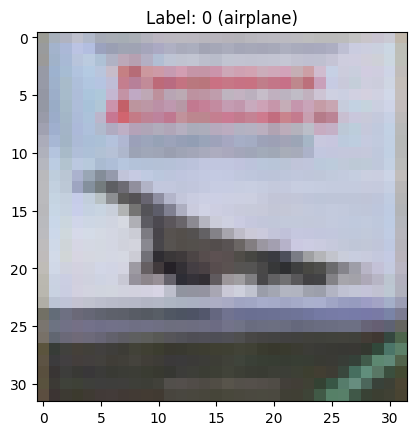

In [8]:
img_idx = 3
(img, label) = dataset[img_idx]
print(f"img type: {type(img)}")

visualize_cifar10_img(img, label)

In [9]:
img = img.unsqueeze(0).to(device)

In [10]:
# Load your base classifier.
base_model = get_model()
base_model.to(device)
base_model.eval()

# Set up the smoothed classifier.
sigma = 0.25  # noise level; adjust as needed
num_classes = 10
smoothed_classifier = Smooth(base_model, num_classes, sigma)

/tmp/ipykernel_1645342/1342317133.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [11]:
# Certification parameters
N0 = 100     # number of samples for initial prediction
N = 10000    # number of samples for certification
alpha = 0.001  # failure probability

# Certify the prediction: returns (predicted_class, certified_radius)
pred_class, certified_radius = smoothed_classifier.certify(img, N0, N, alpha, batch_size=100)
print(f"Label lass: {label}")
print("Predicted class:", pred_class)
print("Certified radius (L2):", certified_radius)

Label lass: 0
Predicted class: 0
Certified radius (L2): 0.5863564867387286


In [12]:
# Add a perturbation with 90% of the certified L2 radius.
# We sample a random noise vector and then scale it to have the desired L2 norm.
noise = torch.randn_like(img, device=device)
noise_flat = noise.view(noise.size(0), -1)  # flatten for norm computation
noise_norm = noise_flat.norm(p=2, dim=1, keepdim=True)  # shape: (1, 1)
desired_norm = 1.0 * certified_radius  # scalar: 90% of the certified radius

# Scale the noise so that its L2 norm equals desired_norm.
scaling_factor = desired_norm / noise_norm.item()
perturbation = noise * scaling_factor

# Create the perturbed image and ensure it stays in valid range [0,1].
perturbed_img = img + perturbation
perturbed_img = torch.clamp(perturbed_img, 0.0, 1.0)

# (Optional) Verify the norm of the perturbation.
perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
print("Perturbation L2 norm:", perturbation_norm)

# (Optional) Check the prediction on the perturbed image.
pred_class_perturbed, _ = smoothed_classifier.certify(perturbed_img, N0, N, alpha, batch_size=100)
print("Predicted class on perturbed image:", pred_class_perturbed)

Perturbation L2 norm: 0.5863564610481262
Predicted class on perturbed image: 0


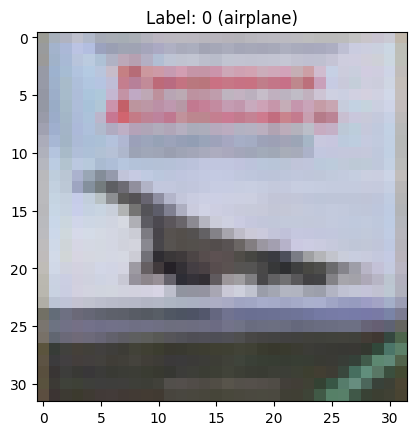

Minimum pixel value: 0.12941177189350128
Maximum pixel value: 0.9176470637321472
Mean pixel value: 0.6070938110351562
Variance of pixel values: 0.04892216622829437


In [13]:
visualize_cifar10_img(img, label)
print_img_statistics(img)

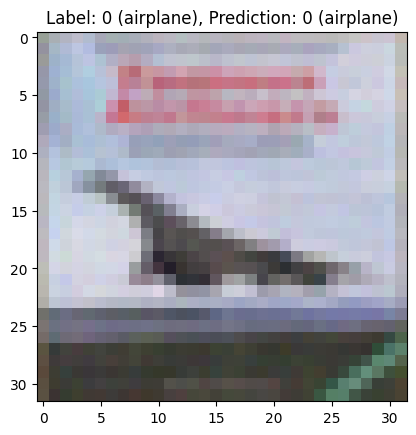

Minimum pixel value: 0.12122095376253128
Maximum pixel value: 0.9384424090385437
Mean pixel value: 0.6070693135261536
Variance of pixel values: 0.04908612370491028


In [14]:
visualize_cifar10_img(perturbed_img, label, pred_class_perturbed)
print_img_statistics(perturbed_img)

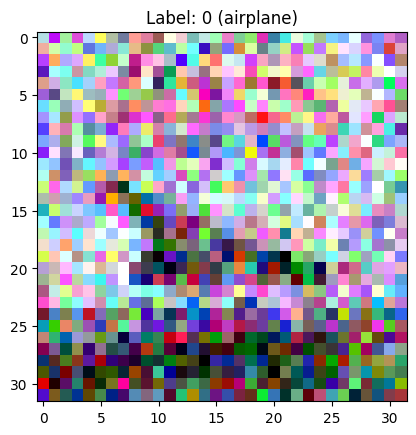

Minimum pixel value: 0.0
Maximum pixel value: 1.0
Mean pixel value: 0.598983645439148
Variance of pixel values: 0.08712491393089294


In [15]:
full_sigma_noise = torch.randn_like(img, device='cuda') * sigma
noisy_img = torch.clamp(img + full_sigma_noise, 0, 1)
visualize_cifar10_img(noisy_img, label)
print_img_statistics(noisy_img)

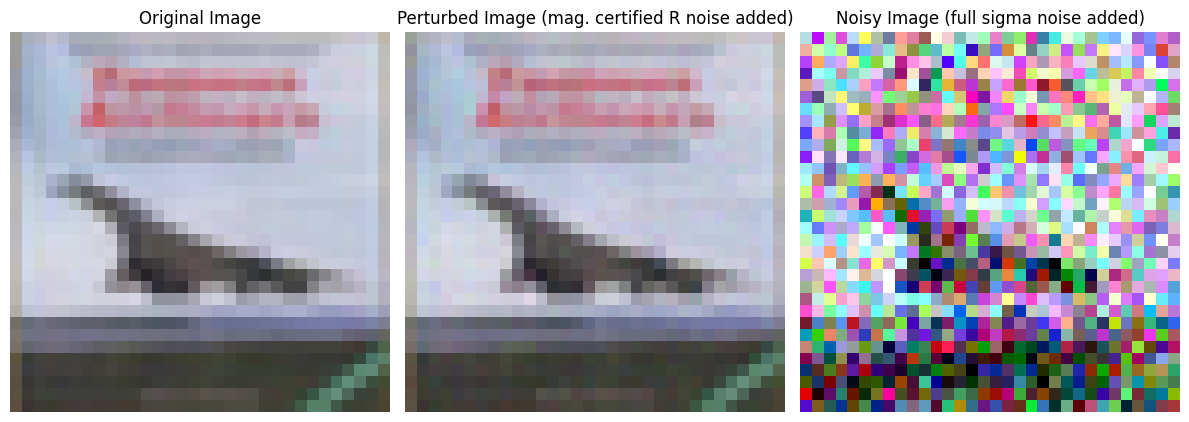

In [16]:
imgs_list = [img, perturbed_img, noisy_img]
titles = ['Original Image', 'Perturbed Image (mag. certified R noise added)', 'Noisy Image (full sigma noise added)']
visualize_cifar10_imgs(imgs_list, titles)

device: cuda
Original prediction: 0
Adversarial prediction: 2


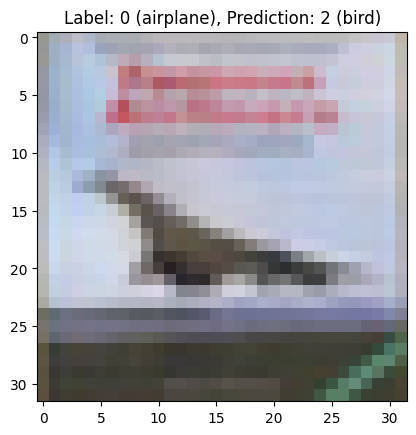

In [17]:
from smooth_attacker import pgd_attack, pgd_attack_l2


(img, label) = dataset[img_idx]
print(f'device: {device}')
# batch of images with size 1
img = img.unsqueeze(0).to(device)
# batch of lables with size 1
label = torch.tensor([label], dtype=torch.int64, device=device)

# Set attack parameters.
epsilon = certified_radius + 0.4   # maximum allowed perturbation (it should be greater than the certified radius for the attack to work)
if epsilon < certified_radius:
    print("Warning: Epsilon is less than the certified radius. The attack may not work as expected.")
alpha_pgd = 0.1     # step size per iteration
num_iter = 40    # total PGD iterations
num_samples = 50 # number of noise samples per iteration for gradient estimation


orig_pred = smoothed_classifier.predict(img, n=N0, alpha=alpha, batch_size=100)
# orig_pred = smoothed_classifier.certify(img, N0, N, alpha, batch_size=100)
print("Original prediction:", orig_pred)
adv_data = pgd_attack_l2(smoothed_classifier, img, label, epsilon, alpha_pgd, num_iter, num_samples, sigma)

# Get the prediction for the adversarial example.
adv_pred = smoothed_classifier.predict(adv_data, n=N0, alpha=alpha, batch_size=100)
# adv_pred = smoothed_classifier.certify(adv_data, N0, N, alpha, batch_size=100)
print("Adversarial prediction:", adv_pred)
visualize_cifar10_img(adv_data, label.item(), adv_pred)

In [18]:
print_img_statistics(adv_data)

Minimum pixel value: 0.126043900847435
Maximum pixel value: 0.9547548294067383
Mean pixel value: 0.6065948605537415
Variance of pixel values: 0.04854807257652283


In [19]:
print(f'adv_data.shape: {adv_data.shape}, img.shape: {img.shape}')

adv_data.shape: torch.Size([1, 3, 32, 32]), img.shape: torch.Size([1, 3, 32, 32])


In [20]:
perturbation = adv_data - img
perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
print("Perturbation L2 norm:", perturbation_norm)

Perturbation L2 norm: 0.9863565564155579


In [21]:
reached_abstain = False
## find the smallest epsilon that can fool the model
for added_eps in np.arange(0.0, 0.5, 0.025):
    epsilon = certified_radius + added_eps   # maximum allowed perturbation (it should be greater than the certified radius for the attack to work)
    alpha_pgd = 0.1     # step size per iteration
    num_iter = 40    # total PGD iterations
    num_samples = 50 # number of noise samples per iteration for gradient estimation


    orig_pred = smoothed_classifier.predict(img, n=N0, alpha=alpha, batch_size=100)
    # orig_pred = smoothed_classifier.certify(img, N0, N, alpha, batch_size=100)
    adv_data = pgd_attack_l2(smoothed_classifier, img, label, epsilon, alpha_pgd, num_iter, num_samples, sigma)

    # Get the prediction for the adversarial example.
    # adv_pred = smoothed_classifier.predict(adv_data, n=N0, alpha=alpha, batch_size=100)
    adv_pred, cer_r = smoothed_classifier.certify(adv_data, N0, N, alpha, batch_size=100)
    print(f'epsilon: {epsilon}, Original prediction: {orig_pred}, Adversarial prediction: {adv_pred}, certified radius: {cer_r}')
    if adv_pred != orig_pred and adv_pred == -1 and not reached_abstain:
        reached_abstain = True
        print("#### Noise level for abstaining:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        print('############')

    if adv_pred != orig_pred and adv_pred != -1:
        print("#### Noise level for uncorrect prediction:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        break

epsilon: 0.5863564867387286, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.14952912342979408
epsilon: 0.6113564867387287, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.1364151603188051
epsilon: 0.6363564867387287, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.11529056058977094
epsilon: 0.6613564867387287, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.09582202219725461
epsilon: 0.6863564867387286, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.07424587112536525
epsilon: 0.7113564867387286, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.053449115221250135
epsilon: 0.7363564867387287, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.03922506512140915
epsilon: 0.7613564867387287, Original prediction: 0, Adversarial prediction: 0, certified radius: 0.024641668173926143
epsilon: 0.7863564867387287, Original prediction: 0, Ad

In [31]:
reached_abstain = False
## find the smallest epsilon that can fool the model
for added_eps in np.arange(0.0, 0.5, 0.025):
    epsilon = certified_radius + added_eps   # maximum allowed perturbation (it should be greater than the certified radius for the attack to work)
    alpha_pgd = 0.1     # step size per iteration
    num_iter = 40    # total PGD iterations
    num_samples = 50 # number of noise samples per iteration for gradient estimation


    orig_pred = smoothed_classifier.predict(img, n=N0, alpha=alpha, batch_size=100)
    # orig_pred = smoothed_classifier.certify(img, N0, N, alpha, batch_size=100)
    adv_data = pgd_attack_l2(smoothed_classifier, img, label, epsilon, alpha_pgd, num_iter, num_samples, sigma)

    # Get the prediction for the adversarial example.
    adv_pred = smoothed_classifier.predict(adv_data, n=N0, alpha=alpha, batch_size=100)
    # adv_pred = smoothed_classifier.certify(adv_data, N0, N, alpha, batch_size=100)
    print(f'epsilon: {epsilon}, Original prediction: {orig_pred}, Adversarial prediction: {adv_pred}')
    if adv_pred != orig_pred and adv_pred == -1 and not reached_abstain:
        reached_abstain = True
        print("#### Noise level for abstaining:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        print('############')

    if adv_pred != orig_pred and adv_pred != -1:
        print("#### Noise level for uncorrect prediction:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        break

epsilon: 0.5936037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6186037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6436037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6686037367889883, Original prediction: 0, Adversarial prediction: -1
#### Noise level for abstaining:
Original prediction: 0
Adversarial prediction: -1
Perturbation L2 norm: 0.6686037182807922
diff certified_radius & Perturbation L2 norm: 0.07499998149180387
Found epsilon: 0.6686037367889883
############
epsilon: 0.6936037367889883, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7186037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7436037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7686037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7936037367889883, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.8186037367889883, Original predicti

In [25]:
reached_abstain = False
## find the smallest epsilon that can fool the model
for added_eps in np.arange(0.0, 0.5, 0.025):
    epsilon = certified_radius + added_eps   # maximum allowed perturbation (it should be greater than the certified radius for the attack to work)
    alpha_pgd = 0.1     # step size per iteration
    num_iter = 40    # total PGD iterations
    num_samples = 50 # number of noise samples per iteration for gradient estimation


    orig_pred = smoothed_classifier.predict(img, n=N0, alpha=alpha, batch_size=100)
    # orig_pred = smoothed_classifier.certify(img, N0, N, alpha, batch_size=100)
    adv_data = pgd_attack_l2(smoothed_classifier, img, label, epsilon, alpha_pgd, num_iter, num_samples, sigma)

    # Get the prediction for the adversarial example.
    adv_pred = smoothed_classifier.predict(adv_data, n=N0, alpha=alpha, batch_size=100)
    # adv_pred = smoothed_classifier.certify(adv_data, N0, N, alpha, batch_size=100)
    print(f'epsilon: {epsilon}, Original prediction: {orig_pred}, Adversarial prediction: {adv_pred}')
    if adv_pred != orig_pred and adv_pred == -1 and not reached_abstain:
        reached_abstain = True
        print("#### Noise level for abstaining:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        print('############')

    if adv_pred != orig_pred and adv_pred != -1:
        print("#### Noise level for uncorrect prediction:")
        print("Original prediction:", orig_pred)
        print("Adversarial prediction:", adv_pred)
        
        perturbation = adv_data - img
        perturbation_norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1).item()
        print("Perturbation L2 norm:", perturbation_norm)
        print(f'diff certified_radius & Perturbation L2 norm: {np.abs(certified_radius - perturbation_norm)}')
        print(f"Found epsilon: {epsilon}")
        break

epsilon: 0.5936037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6186037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6436037367889884, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6686037367889883, Original prediction: 0, Adversarial prediction: 0
epsilon: 0.6936037367889883, Original prediction: 0, Adversarial prediction: -1
#### Noise level for abstaining:
Original prediction: 0
Adversarial prediction: -1
Perturbation L2 norm: 0.6936037540435791
diff certified_radius & Perturbation L2 norm: 0.10000001725459073
Found epsilon: 0.6936037367889883
############
epsilon: 0.7186037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7436037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7686037367889884, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.7936037367889883, Original prediction: 0, Adversarial prediction: -1
epsilon: 0.8186037367889883, Original predictio

device: cuda
image label: 0
Predicted class on attacked image: 0


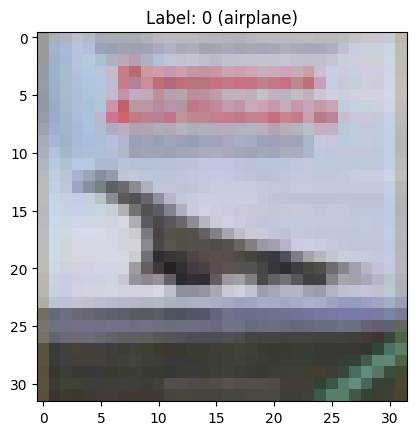

Minimum pixel value: 0.1274707168340683
Maximum pixel value: 0.920033872127533
Mean pixel value: 0.6069102883338928
Variance of pixel values: 0.04889165982604027


In [17]:
from smoothadv.code.attacks import PGD_L2

(img, label) = dataset[img_idx]
print(f'device: {device}')
# batch of images with size 1
imgs = img.unsqueeze(0).to(device)
# batch of lables with size 1
labels = torch.tensor([label], dtype=torch.int64, device=device)

# Define PGD attack parameters
epsilon = 64.0 / 256.0  # Adjust epsilon as needed
attacker = PGD_L2(steps=500, device=device, max_norm=epsilon)

# Prepare a noise vector (using sigma already defined) for the attack
noise = torch.randn_like(imgs, device=device) * sigma

# Perform the PGD attack on the image (using base_model and label as defined earlier)
# onehot_label = torch.zeros(1, num_classes, device=device)
attacked_img = attacker.attack(base_model, imgs, labels, noise=noise, num_noise_vectors=1, targeted=False, no_grad=True)

# get the predicted class of the attacked image
# Note: Ensure to use the base model for prediction
pred_class_attacked, _ = smoothed_classifier.certify(attacked_img, N0, N, alpha, batch_size=10)
print("image label:", labels.item())
print("Predicted class on attacked image:", pred_class_attacked)

# Visualize and print statistics of the attacked image
visualize_cifar10_img(attacked_img, label)
print_img_statistics(attacked_img)